# Guru Charan Bogireddy
# Lab 10

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import matplotlib.pyplot as plt
import os
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize

In [9]:
# import dataset
#train data
trainFolder = pathlib.Path("D:/Conestoga/MachineLearninigIntro/CSCN8010-lab-submissions/students_submissions/8902043/birds_csv/train")
#test data
testFolder = pathlib.Path("D:/Conestoga/MachineLearninigIntro/CSCN8010-lab-submissions/students_submissions/8902043/birds_csv/test")
#valid data
validFolder = pathlib.Path("D:/Conestoga/MachineLearninigIntro/CSCN8010-lab-submissions/students_submissions/8902043/birds_csv/valid")

In [11]:
# Take 3 classes with highest images

# Dictionary to store image count for each class
imagesCount = {}

# Loop through sub directories and update the count for each class
for species in os.listdir(trainFolder):
    speciesPath = os.path.join(trainFolder, species)
    if os.path.isdir(speciesPath):
        imagesCount[species] = len(os.listdir(speciesPath))

#Sort the dictionary
top3 = sorted(imagesCount, key=imagesCount.get, reverse=True)[:3]

print('Top 3 birds with highest images:', top3)

Top 3 birds with highest images: ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


In [12]:
# delete other directories for train folder
for species in os.listdir(trainFolder):
    if species not in top3:
        delete_path_train = os.path.join(trainFolder, species)
        shutil.rmtree(delete_path_train)

# delete other directories for test folder
for species in os.listdir(testFolder):
    if species not in top3:
        delete_path_test = os.path.join(testFolder, species)
        shutil.rmtree(delete_path_test)

# delete other directories for test folder
for species in os.listdir(validFolder):
    if species not in top3:
        delete_path_valid = os.path.join(validFolder, species)
        shutil.rmtree(delete_path_valid)

2. Use data-augmentation to increase the number of training images. You are encouraged to try out various augmentation methods supported by Keras. The rule of thumb is that as long as an augmentation produces realistic images - it is probably a good idea to add it.(2 point)

In [13]:
train_dataset = image_dataset_from_directory(
    trainFolder,
    image_size=(224,224),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    validFolder,
    image_size=(224,224),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    testFolder,
    image_size=(224,224),
    batch_size=32
)

Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


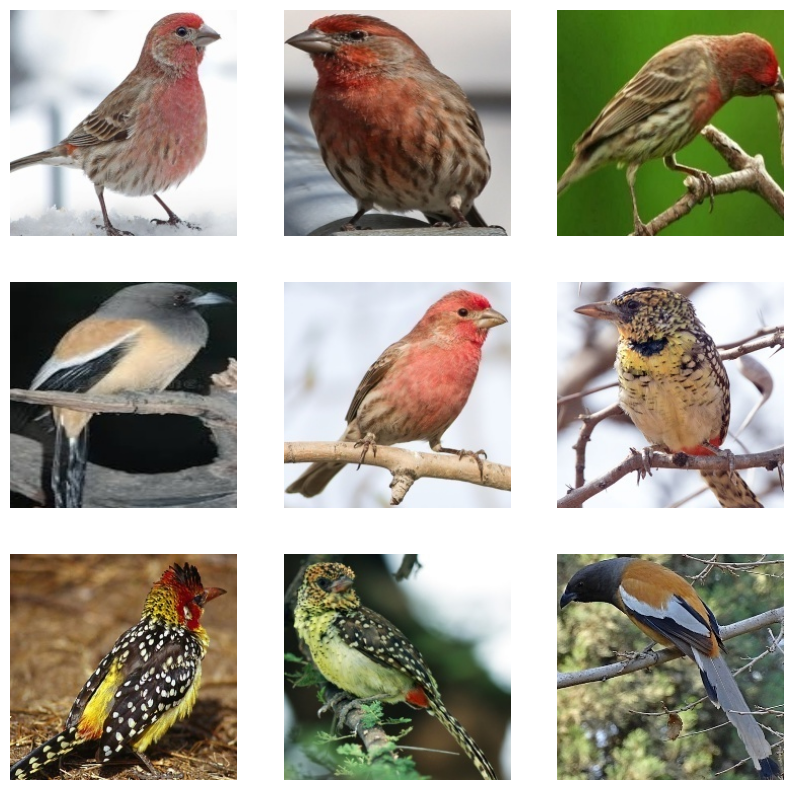

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


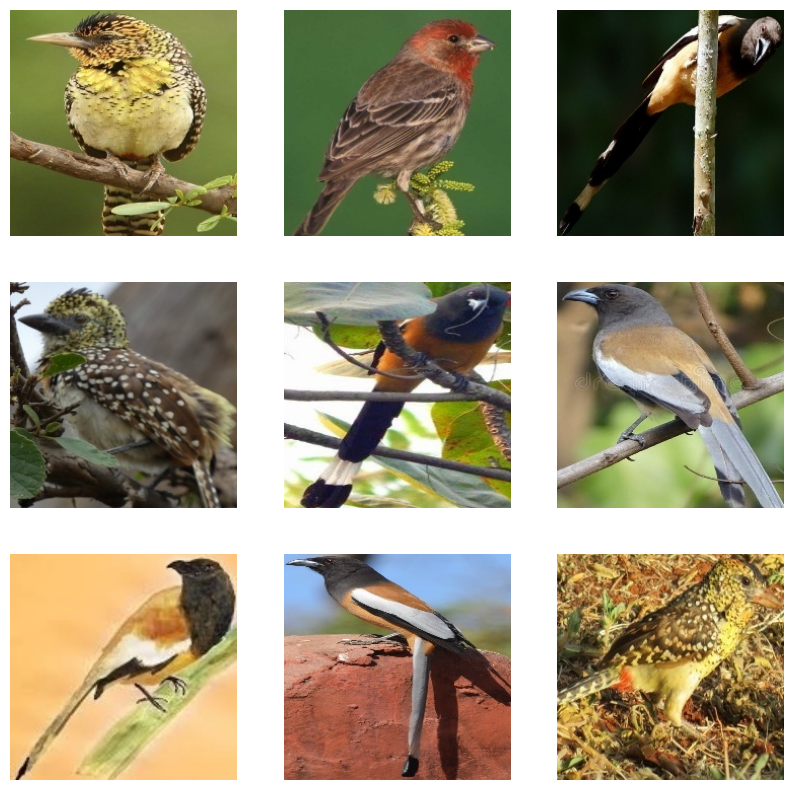

In [15]:
# use keras function of ImageDataGenerator.flow_from_directory

data_generator = ImageDataGenerator(
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = data_generator.flow_from_directory(
    trainFolder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = data_generator.flow_from_directory(
    validFolder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# display some augmented training images

# get images and labels from train_generator
images, _ = next(train_generator)

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.axis("off")
plt.show()# use keras function of ImageDataGenerator.flow_from_directory

data_generator = ImageDataGenerator(
    horizontal_flip = True,
    fill_mode = 'nearest'
)

train_generator = data_generator.flow_from_directory(
    trainFolder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = data_generator.flow_from_directory(
    validFolder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# display some augmented training images

# get images and labels from train_generator
images, _ = next(train_generator)

plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.axis("off")
plt.show()

3.Fine-Tune VGG16 (pre-trained on imagenet), to classify the 3 classes (2 points)

In [16]:
# load pre-trained VGG16 model from imagenet
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

58889256/58889256 [==============================] - 5s 0us/step


In [17]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
# add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a new dense layer
x = Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)

# 3 classes
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [20]:
# freeze all layers of pretrained model for fine-tuning
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
model.compile(loss='categorical_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

In [22]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
24/24 [==============================] - 147s 6s/step - loss: 2.5642 - accuracy: 0.7581 - val_loss: 0.2083 - val_accuracy: 0.8667
Epoch 2/10
24/24 [==============================] - 136s 6s/step - loss: 0.4913 - accuracy: 0.9556 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 142s 6s/step - loss: 0.1118 - accuracy: 0.9745 - val_loss: 7.8665e-04 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 143s 6s/step - loss: 0.1084 - accuracy: 0.9812 - val_loss: 6.7552e-07 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 143s 6s/step - loss: 0.0608 - accuracy: 0.9866 - val_loss: 9.5917e-06 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 136s 6s/step - loss: 0.0581 - accuracy: 0.9892 - val_loss: 3.7350e-05 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 159s 7s/step - loss: 0.0209 - accuracy: 0.9960 - val_loss: 0.0029 - val_accuracy: 1.00

4.Explore the model performance: accuracy, confusion metric, precision, recall, F1-score, precision-recall curve and its area under the curve (AUC). Explore specific examples in which the model failed to predict correctly. (2 points)

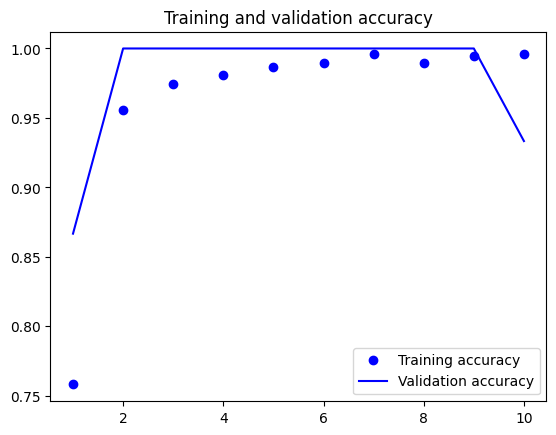

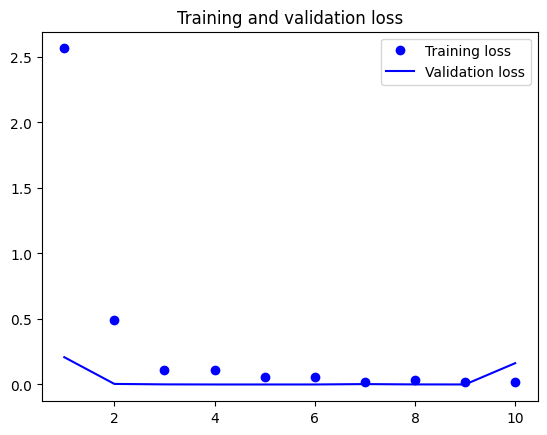

In [23]:
# Accuracy for training and validation
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [24]:
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 2s 2s/step - loss: 0.1476 - accuracy: 0.9333
Test accuracy: 0.933


In [25]:
# Confusion matrix, Precision, Recall and F1-score
y_pred = model.predict(validation_generator)
y_pred_class = np.argmax(y_pred, axis=1)

y_true = validation_generator.classes

# confusion matrix
cm = confusion_matrix(y_true, y_pred_class)

# precision, recall and F1-score
print(classification_report(y_true, y_pred_class, target_names=validation_generator.class_indices.keys()))

1/1 [==============================] - 3s 3s/step
                  precision    recall  f1-score   support

D-ARNAUDS BARBET       0.50      0.40      0.44         5
     HOUSE FINCH       0.67      0.80      0.73         5
    RUFOUS TREPE       0.60      0.60      0.60         5

        accuracy                           0.60        15
       macro avg       0.59      0.60      0.59        15
    weighted avg       0.59      0.60      0.59        15



AUC for D-ARNAUDS BARBET: 0.55739898989899
AUC for HOUSE FINCH: 0.6784615384615384
AUC for RUFOUS TREPE: 0.7175974025974026


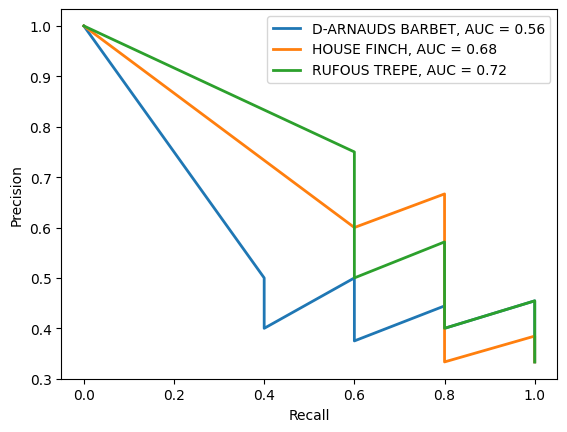

In [26]:
# convert true labels to one-hot encoding for multi-class
y_true_one_hot = to_categorical(y_true)
class_names = {v: k for k, v in validation_generator.class_indices.items()}

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], y_pred[:, i])
    auc_score = auc(recall, precision)
    class_name = class_names[i]
    print(f'AUC for {class_name}: {auc_score}')
    plt.plot(recall, precision, lw=2, label='{}, AUC = {:.2f}'.format(class_name, auc_score))

# plot

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

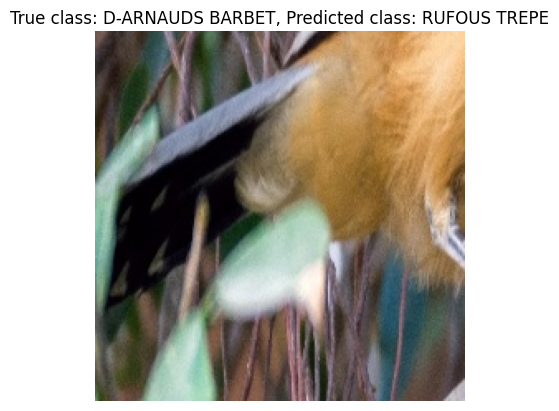

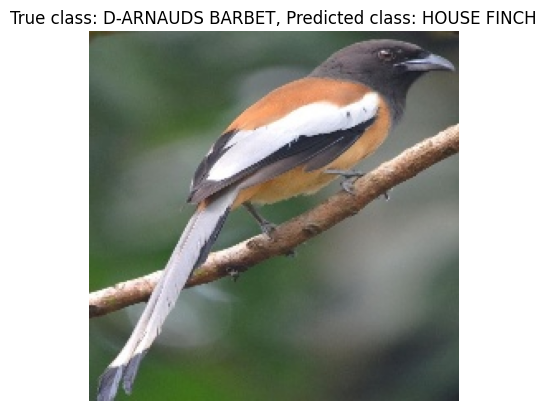

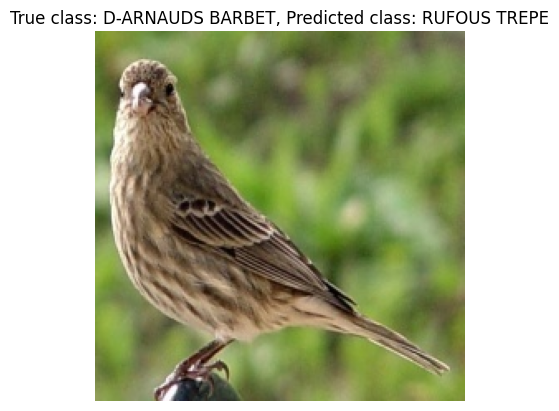

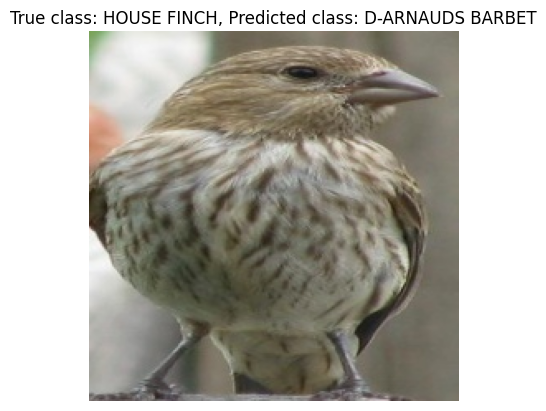

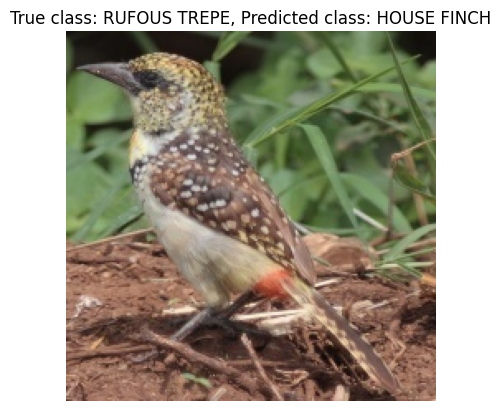

In [27]:
# explore incorrectly predicted examples
misclassfied_index = np.where(y_pred_class != y_true)[0]

# plot specific examples
for index in misclassfied_index[:5]:
    # get image from corresponding batch
    img_batch, _ = validation_generator[index // validation_generator.batch_size]
    img = img_batch[index % validation_generator.batch_size]
    
    true_class_name = class_names[y_true[index]]
    predicted_class_name = class_names[y_pred_class[index]]

    plt.imshow(img.astype('uint8'))
    plt.title(f'True class: {true_class_name}, Predicted class: {predicted_class_name}')
    plt.axis('off')
    plt.show()